In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os

#import excursion
import sys
sys.path.insert(0, '/home/irina/Documents/PROJECTS/excursion/excursion')
sys.path.insert(0, '/home/irina/Documents/PROJECTS/excursion/excursion/testcases/')

import testcases.oned_fast as scandetails
import excursion.optimize 


import numpy as np
import excursion.utils as utils


sys.path.insert(0, '/home/irina/Documents/PROJECTS/excursion/excursion/utils/')
from utils import point_entropy, mesh2points, points2mesh, values2mesh

import datetime

sys.path.insert(0, '/home/irina/Documents/PROJECTS/excursion/excursion/plotting/')
import plotting.onedim as plots

np.warnings.filterwarnings('ignore')

import math

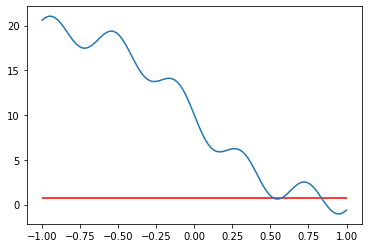

In [3]:
for func in scandetails.truth_functions:
    plt.plot(scandetails.plotX.ravel(),func(scandetails.plotX).ravel(), label=str(func))
    
for thr in scandetails.thresholds:
    plt.hlines(thr, np.min(scandetails.plotX),np.max(scandetails.plotX), colors = 'red', label=str(thr))


In [4]:
import torch
y_true = func(scandetails.plotX).ravel()
X = torch.tensor(scandetails.plotX.ravel())

### 1) GP model specification
prior:
 - RBF kernel 
 - constant mean

In [5]:
import gpytorch

In [6]:
# simplest form of GP model RBF with constant mean prior, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### 2) Likelihood / observational model

excursion: $\epsilon = 0$

In [7]:
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=0)

### 3) Model

initialization: $x_0$ (2 points)

In [8]:
np.random.seed(1)
X_train = torch.from_numpy(\
          np.random.uniform(scandetails.plot_rangedef[:,0],scandetails.plot_rangedef[:,1], size = (2,)) )

y_train = torch.from_numpy(\
          np.array([scandetails.truth_functions[0](np.asarray([x]))[0] for x in X_train]) )

print('X_0 = ', X_train)
print('f(X_0) = ', y_train)

X_0 =  tensor([-0.1660,  0.4406], dtype=torch.float64)
f(X_0) =  tensor([14.1128,  2.4481], dtype=torch.float64)


calculate posterior of GP given the two init points

In [9]:
model = ExactGPModel(X_train, y_train, likelihood)
kernel = model.covar_module

#set hyperparameters for testing
#set C=1 l=1
kernel.base_kernel.lengthscale = torch.tensor([1.])
kernel.outputscale = torch.tensor([1.])

print('model ', model)

model  ExactGPModel(
  (likelihood): FixedNoiseGaussianLikelihood(
    (noise_covar): FixedGaussianNoise()
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)


### 4) Acquisition of new points maximizing info gain

In [10]:
#Goal
#newx, acqvals = excursion.optimize.gridsearch(gps, X, scandetails)
N_UPDATES = 10
gps = [model] #list of GPs
thresholds = [0.7]
xcandidate = torch.tensor([X[20]])
print('xcandidate: ', xcandidate)

xcandidate:  tensor([-0.5960], dtype=torch.float64)


In [11]:
#call info gain
sys.path.insert(0, '/home/irina/Documents/PROJECTS/excursion/excursion/optimize/')
import optimize.core as optimizecore
info_gain_candidate = optimizecore.info_gain_gpytorch(xcandidate, gps, thresholds, X)
print('info gain of xcandidate = '+str(xcandidate[0])+' given training set :', info_gain_candidate)

info gain of xcandidate = tensor(-0.5960, dtype=torch.float64) given training set : tensor(-0.0915, grad_fn=<NegBackward>)


In [28]:
sys.path.insert(0, '/home/irina/Documents/PROJECTS/excursion/excursion/optimize')
import optimize as optimize
import imp
imp.reload(optimize)
imp.reload(optimizecore)
newx, acqvals = optimize.gridsearch_gpytorch(gps, X, scandetails)

info_gain
taking new x. best non-existent index 0 [-0.15151515]


In [ ]:
\